In [1]:
# Packages
library(tidyverse)
# For cleaning names
library(janitor)
# Best subset selection 
library(leaps)
# For tidy function
library(broom)
# For joining plots
library(cowplot)
# For lasso and ridge regressions
library(glmnet)
# For pls and pcr regressions
library(pls)
# For tables
library(flextable)

── Attaching packages ──────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-3


Attaching package: ‘pls’


The following object is masked from ‘package:stats’:

    loadings



Attaching package: ‘flextable’


The following object is masked from ‘package:purrr’:

    compose




In [2]:
# Load data
dataset_math_performance  <- read.csv("../../../data/clean_data_student_math_performance.csv", 
                                      header=TRUE) 

In [3]:
# Remove response variable
dataset_math_performance <- 
  dataset_math_performance %>% 
    dplyr::select(-c(g3_binary, X)) %>% 
        
        # Transform variables to numeric
        mutate(g3 = as.numeric(g3),
               g2 = as.numeric(g2),
               g1 = as.numeric(g1),
               absences = as.numeric(absences)) %>%
        # Transform chr type to factor
        mutate(across(where(is.character), as.factor))

# Split data into training and testing

In [4]:
set.seed(666)
# slip data into train and test

# Get index
train_index <- sample(1:nrow(dataset_math_performance),
                      (nrow(dataset_math_performance)*75)/100)

# Train set
math_performance_train <- dataset_math_performance[train_index,]

# Testing set
math_performance_test <- dataset_math_performance[-train_index,]
# This is done for fitting ridge and lasso

# Full dataset
x_var_math_full <- model.matrix(g3 ~., data = dataset_math_performance)[,-1]
y_var_math_full  <- dataset_math_performance$g3

# Training dataset
x_var_train <- model.matrix(g3 ~., data = math_performance_train)[,-1]
y_var_train <- math_performance_train$g3

# Test set

x_var_test <- model.matrix(g3 ~., data = math_performance_test)[,-1]
y_var_test <- math_performance_test$g3

# Best Subset Model Multiple linear regression

In [5]:
mult_reg_train <- regsubsets(g3 ~., nvmax = 32, 
                             nbest = 1,
                             method="exhaustive", 
                             data = math_performance_train)

mult_reg_train_summary <- summary(mult_reg_train)

In [6]:
which.min(mult_reg_train_summary$cp)

[1] 10

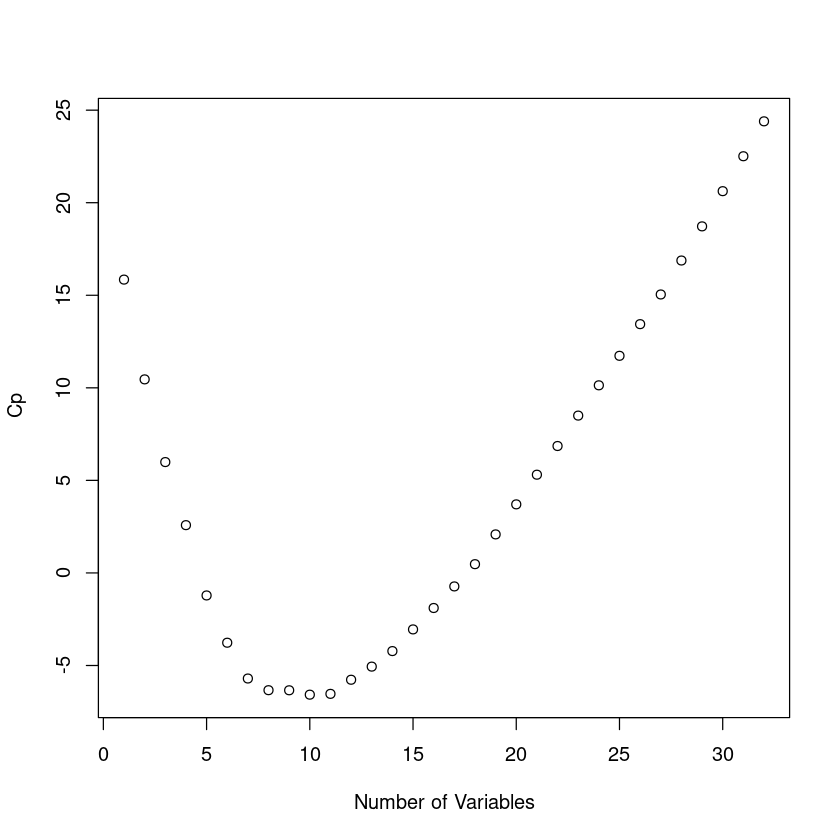

In [7]:
# Select best multiple regression model
plot(mult_reg_train_summary$cp , xlab =" Number of Variables ", ylab =" Cp",type="p")

In [8]:
# Model from Cp 
coef(mult_reg_train, id = 10)

(Intercept)           sexM            age   fjobservices guardianmother 
   0.008138162    0.391696733   -0.203253402   -0.492229262    0.407780563 
 activitiesyes    romanticyes         famrel       absences             g1 
  -0.375778401   -0.442052606    0.308341139    0.049140302    0.185216659 
            g2 
   0.957426695

In [9]:
# Refit the best subset model
best_mult_reg_train <- lm(g3 ~ sex + age + fjob + guardian +  + romantic + 
                               famrel + activities + absences + g1 +g2 ,  
                           data = math_performance_train)

# Ridge regression

In [10]:
ridge_math_train <- cv.glmnet(x_var_train, y_var_train, alpha = 0)

best_lambda_ridge_train <- ridge_math_train$lambda.1

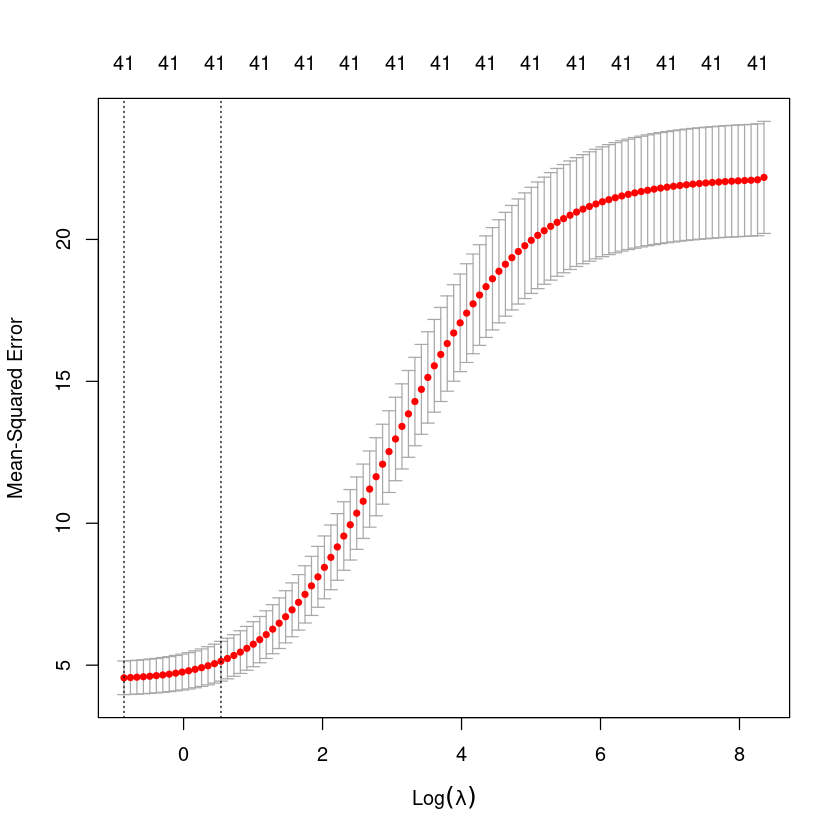

In [11]:
plot(ridge_math_train)

# Lasso regression

In [12]:
lasso_math_train <- cv.glmnet(x_var_train, y_var_train, alpha = 1)
best_lambda_lasso_train <- lasso_math_train$lambda.1se

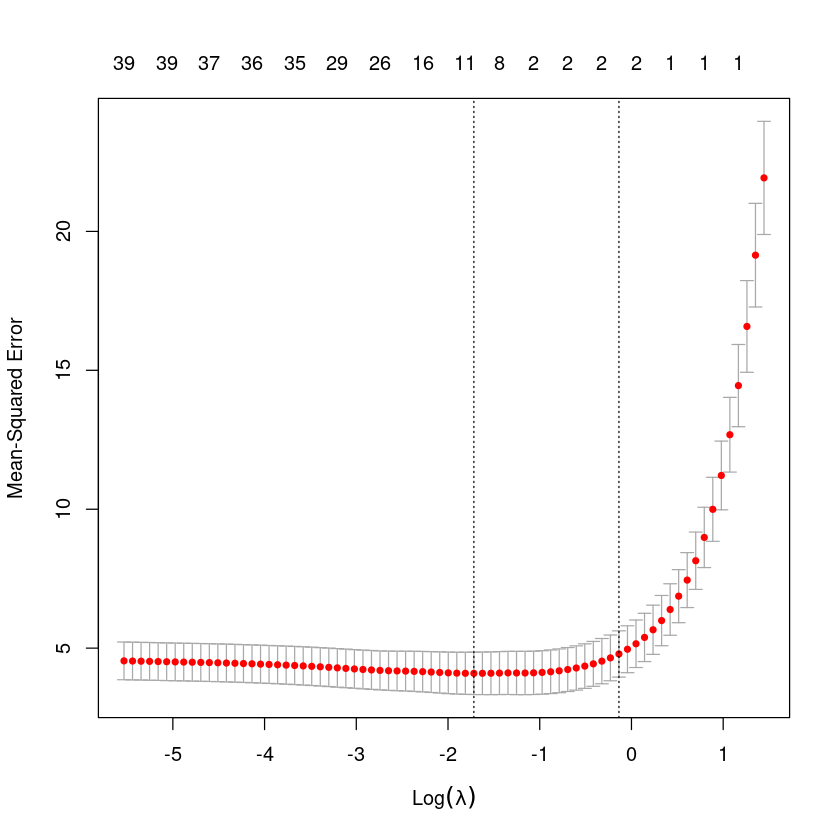

In [13]:
plot(lasso_math_train)

# Principal components regression

In [14]:
pcr_math_train <- pcr(g3 ~ ., data = math_performance_train, 
                          scale = TRUE , 
                          validation = "CV")

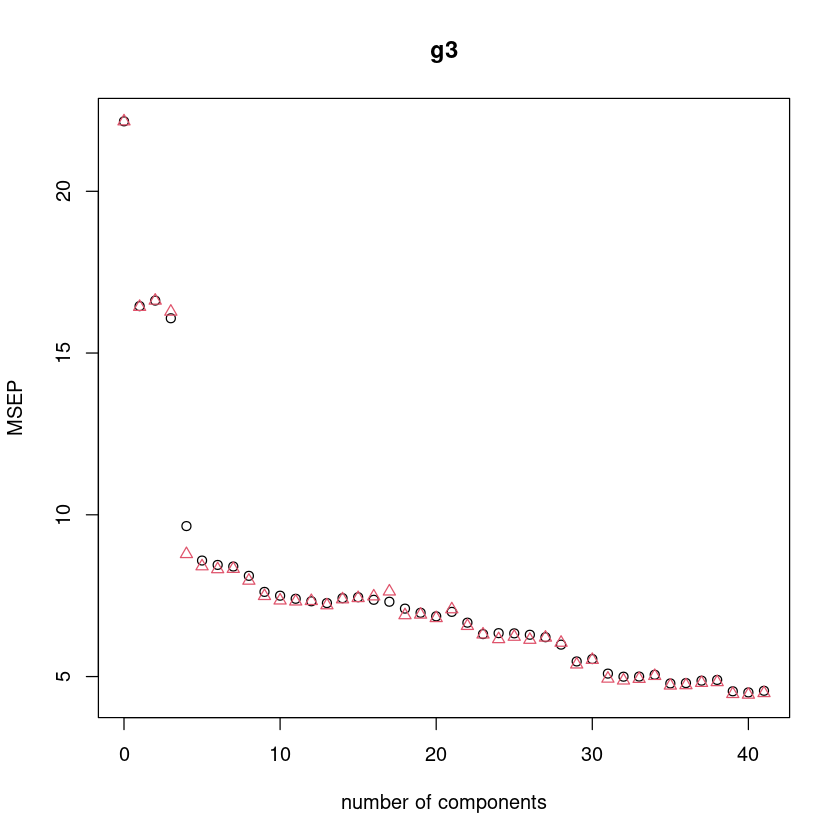

In [15]:
validationplot(pcr_math_train, val.type = "MSEP", type = "p")

In [16]:
pls_math_train <- plsr(g3 ~ ., data = math_performance_train, 
                          scale = TRUE , 
                          validation = "CV")

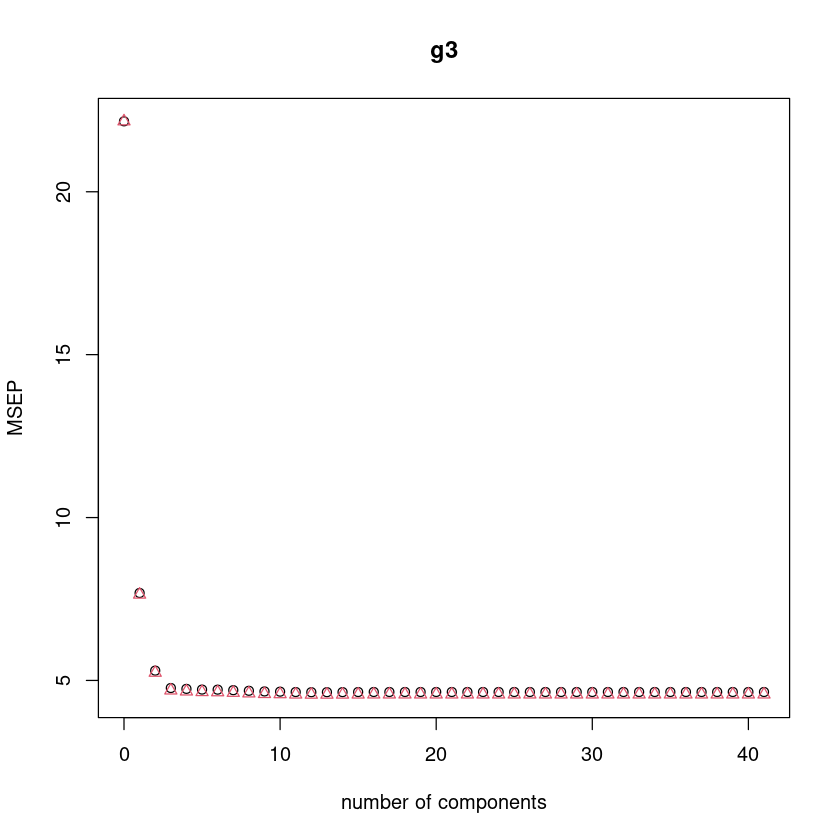

In [17]:
validationplot(pls_math_train, val.type = "MSEP", type = "p")

# Estimate training and testing error

## Multiple linear regression MSE

In [18]:
# Training error
# best_mult_reg_train
mult_mse_train <- summary(best_mult_reg_train)$sigma^2


# Testing error
mult_pred <- predict(best_mult_reg_train, newx = math_performance_test)
mult_mse_test <- mean((mult_pred - math_performance_test$g3)^2)

Warning message in mult_pred - math_performance_test$g3:
“longer object length is not a multiple of shorter object length”


# Ridge regression MSE

In [19]:
# MSE train
ridge_pred_train <- predict(ridge_math_train, 
                            s = ridge_math_train$lambda.1se,
                            newx = x_var_train)

# Training error
ridge_mse_train <- mean((ridge_pred_train - y_var_train)^2) 

# MSE test
ridge_pred_test <- predict(ridge_math_train, 
                            s = ridge_math_train$lambda.1se,
                            newx = x_var_test)
# Test error
ridge_mse_test <- mean((ridge_pred_test - y_var_test)^2) 

# Lasso regression MSE

In [20]:
# MSE train
lasso_pred_train <- predict(lasso_math_train, 
                            s = lasso_math_train$lambda.1se,
                            newx = x_var_train)

# Training error
lasso_mse_train <- mean((lasso_pred_train - y_var_train)^2) 

# MSE test
lasso_pred_test <- predict(lasso_math_train, 
                            s = lasso_math_train$lambda.1se,
                            newx = x_var_test)
# Test error
lasso_mse_test <- mean((lasso_pred_test - y_var_test)^2) 

# PCR MSE

In [21]:
# Train error
pcr_pred_train <- predict(pcr_math_train, data = math_performance_train , ncomp = 5 )
pcr_mse_train <- mean((pcr_pred_train - math_performance_train$g3)^2)

# Test error
pcr_pred_test <- predict(pcr_math_train, math_performance_test, ncomp = 5 )
pcr_mse_test <- mean((pcr_pred_test - math_performance_test$g3)^2)

# PLSR MSE

In [22]:
# Train error
pls_pred_train <- predict(pls_math_train, data = math_performance_train, ncomp = 2)
pls_mse_train <- mean((pls_pred_train - math_performance_train$g3)^2)

# Test error
pls_pred_test <- predict(pls_math_train, math_performance_test, ncomp = 2)
pls_mse_test <- mean((pls_pred_test - math_performance_test$g3)^2)

# Table 1

In [23]:
(table_4 <- tribble(
~model, ~mse_train, ~mse_test,~difference,
"MLR", mult_mse_train,  mult_mse_test,  abs(mult_mse_test  - mult_mse_train),
"PCR",   pcr_mse_train,   pcr_mse_test,   abs(pcr_mse_test   - pcr_mse_train),
"PLS",   pls_mse_train,   pls_mse_test,   abs(pls_mse_test   - pls_mse_train),
"RIDGE", ridge_mse_train, ridge_mse_test, abs(ridge_mse_test - ridge_mse_train),
"LASSO", lasso_mse_train, lasso_mse_test, abs(lasso_mse_test - lasso_mse_train)) %>% 
  flextable())


a flextable object.
col_keys: `model`, `mse_train`, `mse_test`, `difference` 
header has 1 row(s) 
body has 5 row(s) 
original dataset sample: 
  model mse_train  mse_test difference
1   MLR  3.666164 31.270229 27.6040650
2   PCR  7.982341  6.688145  1.2941958
3   PLS  4.353050  4.023175  0.3298759
4 RIDGE  4.173689  3.895818  0.2778710
5 LASSO  4.747010  3.541852  1.2051580

# Select the best models from Table 1 and refit models to the entire data


# Ridge fitted to the full dataset

In [24]:
ridge_math_performance <- cv.glmnet(x_var_math_full, y_var_math_full, alpha = 0)

In [25]:
coefs_ridge_pred <- predict(ridge_math_performance, type = "coefficients" ,
                       s = best_lambda_ridge_train)

coefs_ridge <- as.data.frame(coefs_ridge_pred[,c(1)])


colnames(coefs_ridge) <- "value"

ridge_plot <- coefs_ridge %>% 
  rownames_to_column(var = "coefficient") %>% 
    mutate(coefficient = factor(coefficient)) %>% 
    ggplot(data = ., aes(x = reorder(coefficient, value), y = value)) +
    geom_point(fill = "#ed3324", color = "white", size = 4, shape = 21) + 
    geom_hline(aes(yintercept = 0),linetype = 6) +
    theme_bw() +
    coord_flip() +
    ylab("Coefficient value") + xlab("Predictors") +
    ggtitle("Ridge Regression coefficients")

# LASSO fitted to the full dataset

In [26]:
lasso_math_performace <- cv.glmnet(x_var_math_full, y_var_math_full, alpha = 1)

In [27]:
coef_lasso_pred <- predict(lasso_math_performace, type = "coefficients" , 
                      s = best_lambda_lasso_train)


coefs_lasso <- as.data.frame(coef_lasso_pred[,c(1)])


coefs_lasso <- 
  coefs_lasso %>%   
    rownames_to_column(var = "coefficient")  %>% 
    mutate(coefficient = factor(coefficient)) %>% 
    rename(value = "coef_lasso_pred[, c(1)]")

In [28]:
lasso_plot <- ggplot(data = coefs_lasso, aes(x = reorder(coefficient,value), y = value)) +
    geom_point(fill = "#ed3324", color = "white", size = 4, shape = 21) + 
    geom_hline(aes(yintercept = 0),linetype = 6) +
    theme_bw() +
    coord_flip() +
    ylab("Coefficient value") + xlab("Predictors") +
    ggtitle("Lasso Regression coefficients")

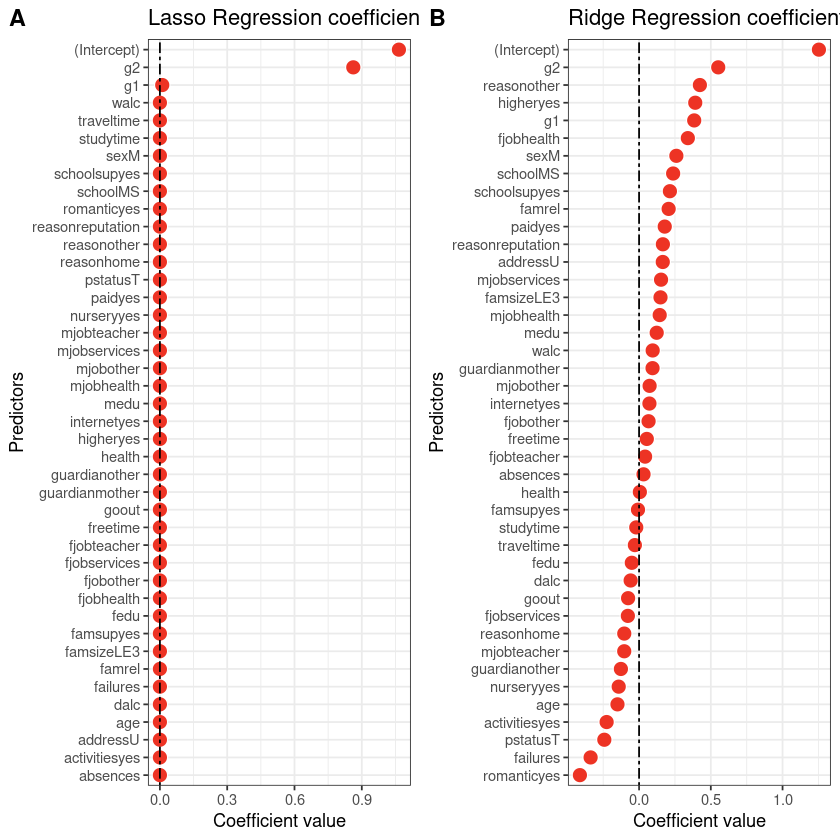

In [29]:
plot_grid(lasso_plot, ridge_plot, nrow = 1, labels = "AUTO")